In [47]:
from utils import find_matching_experiments, parse_sim_results, parse_vllm_results, calculate_errors, plot_results
import os

vllm_dir = "../../inference-sim/largesweep"
sim_dir = "../../inference-sim/results/sweep_params"

sweep_configs = {
    'num_prompts': [100, 200, 400, 800, 1600],
    'request_rate': [4,8,16,32,64,128],
    'temperature': [0.0],
    'max_num_batched_tokens': [256, 512, 1024, 2048, 4096, 8192],
    'long_prefill_token_threshold': [16, 32, 64, 128, 256, 512, 1024],
    'datasets': [{'name': 'sharegpt', 'path': 'ShareGPT_V3_unfiltered_cleaned_split.json'}]
}


# graphing parameters
x_axis = 'num_prompts'
y_axis = 'request_rate'
metrics = ['ttft_accuracy', 'tpot_accuracy', 'e2e_accuracy', 'duration_accuracy']
plotting_data = {}
for metric in metrics:
    plotting_data[metric] = {}

# Find matching experiments
matching_pairs = find_matching_experiments(sim_dir, vllm_dir, sweep_configs)

print(f"Found {len(matching_pairs)} matching experiment pairs")

# Process each pair
for sim_file, vllm_file, config in matching_pairs:
    print(f"\nProcessing: {os.path.basename(sim_file)}")
    
    # Parse results
    sim_results = parse_sim_results(sim_file)
    vllm_results = parse_vllm_results(vllm_file)
    
    
    # Calculate errors
    errors = calculate_errors(sim_results, vllm_results)

    print(errors)
    # Print results
    for metric, value in errors.items():
        if metric in metrics:
            if plotting_data[metric].get(str(config[y_axis])) is None:
                plotting_data[metric][str(config[y_axis])] = {}
            if str(config[x_axis]) not in plotting_data[metric][str(config[y_axis])]:
                plotting_data[metric][str(config[y_axis])][str(config[x_axis])] = []
            plotting_data[metric][str(config[y_axis])][str(config[x_axis])].append(value)


Found 1151 matching experiment pairs

Processing: exp_100p_4r_0.0t_256mbt_16lpt_sharegpt.txt
{'ttft_mse': np.float64(0.00028443720568173284), 'ttft_accuracy': np.float64(82.97193074456517), 'tpot_mse': np.float64(2.045092416708838e-05), 'tpot_accuracy': np.float64(92.20955129020318), 'e2e_mse': np.float64(0.045327090977224024), 'e2e_accuracy': np.float64(87.57191211158701), 'duration_accuracy': 99.5469861475103}

Processing: exp_100p_4r_0.0t_256mbt_32lpt_sharegpt.txt
{'ttft_mse': np.float64(0.00011469015909836313), 'ttft_accuracy': np.float64(81.25695993594947), 'tpot_mse': np.float64(2.1783383465085932e-05), 'tpot_accuracy': np.float64(91.99254943790955), 'e2e_mse': np.float64(0.046487855600438305), 'e2e_accuracy': np.float64(87.1795802263487), 'duration_accuracy': 99.34635612321563}

Processing: exp_100p_4r_0.0t_256mbt_64lpt_sharegpt.txt
{'ttft_mse': np.float64(3.806387433172361e-05), 'ttft_accuracy': np.float64(82.7027540331855), 'tpot_mse': np.float64(2.1415112964112837e-05), 'tpot

In [48]:
import matplotlib.pyplot as plt
import numpy as np
def calculate_averages(plotting_data):
    """Calculate averages for each metric, y_axis, x_axis combination"""
    averaged_data = {}
    
    for metric in plotting_data:
        averaged_data[metric] = {}
        for y_val in plotting_data[metric]:
            averaged_data[metric][y_val] = {}
            for x_val in plotting_data[metric][y_val]:
                values = plotting_data[metric][y_val][x_val]
                averaged_data[metric][y_val][x_val] = np.mean(values)
    
    return averaged_data

def create_grouped_bar_chart(averaged_data, metric, x_axis_values, y_axis_values):
    """Create a grouped bar chart for a specific metric"""
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert string values to integers for proper sorting
    x_vals = sorted([int(x) for x in x_axis_values])
    y_vals = sorted([int(y) for y in y_axis_values])
    
    # Number of groups (y_axis values) and bars per group (x_axis values)
    n_groups = len(y_vals)
    n_bars_per_group = len(x_vals)
    
    # Set the width of bars and positions
    bar_width = 0.8 / n_bars_per_group
    group_positions = np.arange(n_groups)
    
    # Colors for different x_axis values
    colors = plt.cm.Set3(np.linspace(0, 1, n_bars_per_group))
    
    # Create bars for each x_axis value
    for i, x_val in enumerate(x_vals):
        values = []
        for y_val in y_vals:
            y_str = str(y_val)
            x_str = str(x_val)
            if y_str in averaged_data[metric] and x_str in averaged_data[metric][y_str]:
                values.append(averaged_data[metric][y_str][x_str])
            else:
                values.append(0)  # Default value if data is missing
        
        # Calculate position for this set of bars
        positions = group_positions + i * bar_width - (n_bars_per_group - 1) * bar_width / 2
        
        # Create bars
        bars = ax.bar(positions, values, bar_width, 
                     label=f'{x_axis}={x_val}', color=colors[i], alpha=0.8)
        
        # Add value labels on top of bars
        for bar, value in zip(bars, values):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    ax.set_xlabel(f'{y_axis.replace("_", " ").title()}', fontsize=12)
    ax.set_ylabel(f'{metric.replace("_", " ").title()}', fontsize=12)
    ax.set_title(f'{metric.replace("_", " ").title()} by {y_axis.replace("_", " ").title()} and {x_axis.replace("_", " ").title()}', 
                fontsize=14, fontweight='bold')
    
    # Set x-axis labels
    ax.set_xticks(group_positions)
    ax.set_xticklabels([f'{y_val}' for y_val in y_vals])
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    return fig

def plot_all_metrics(plotting_data, sweep_configs, x_axis, y_axis):
    """Create plots for all metrics"""
    # Calculate averages
    averaged_data = calculate_averages(plotting_data)
    
    # Get unique values for x and y axes
    x_axis_values = [str(x) for x in sweep_configs[x_axis]]
    
    # Get y_axis values from the data (in case not all values are present)
    y_axis_values = set()
    for metric in averaged_data:
        y_axis_values.update(averaged_data[metric].keys())
    y_axis_values = sorted(list(y_axis_values), key=int)
    
    # Create a plot for each metric
    for metric in averaged_data:
        if averaged_data[metric]:  # Only plot if data exists
            fig = create_grouped_bar_chart(averaged_data, metric, x_axis_values, y_axis_values)
            
            # Save the plot
            plt.savefig(f'{metric}_grouped_bar_chart.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    return averaged_data

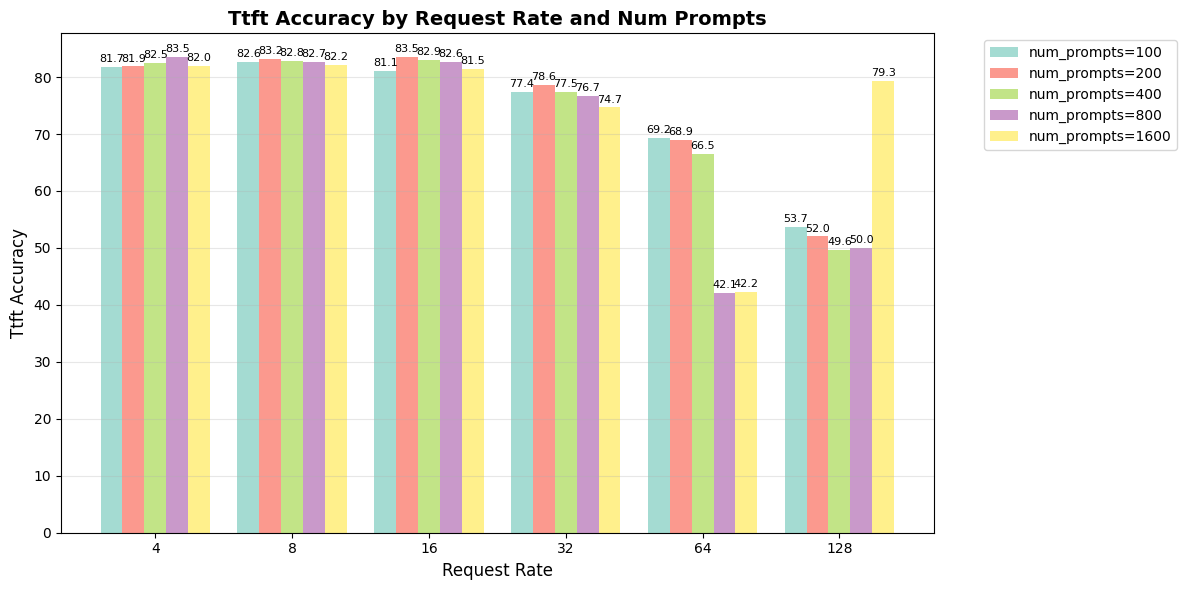

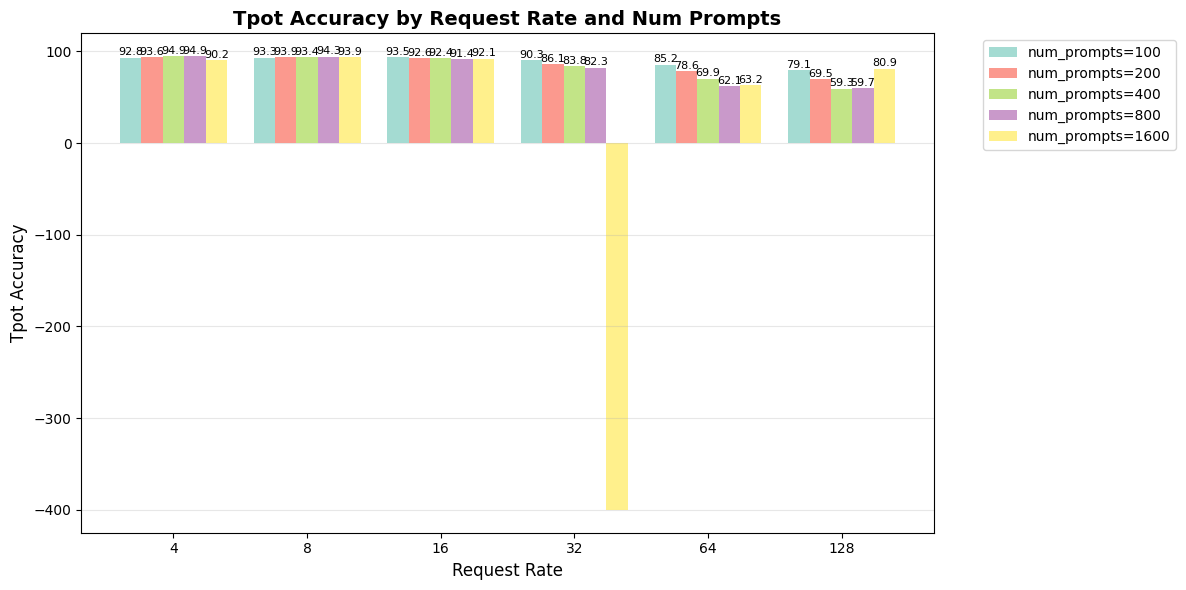

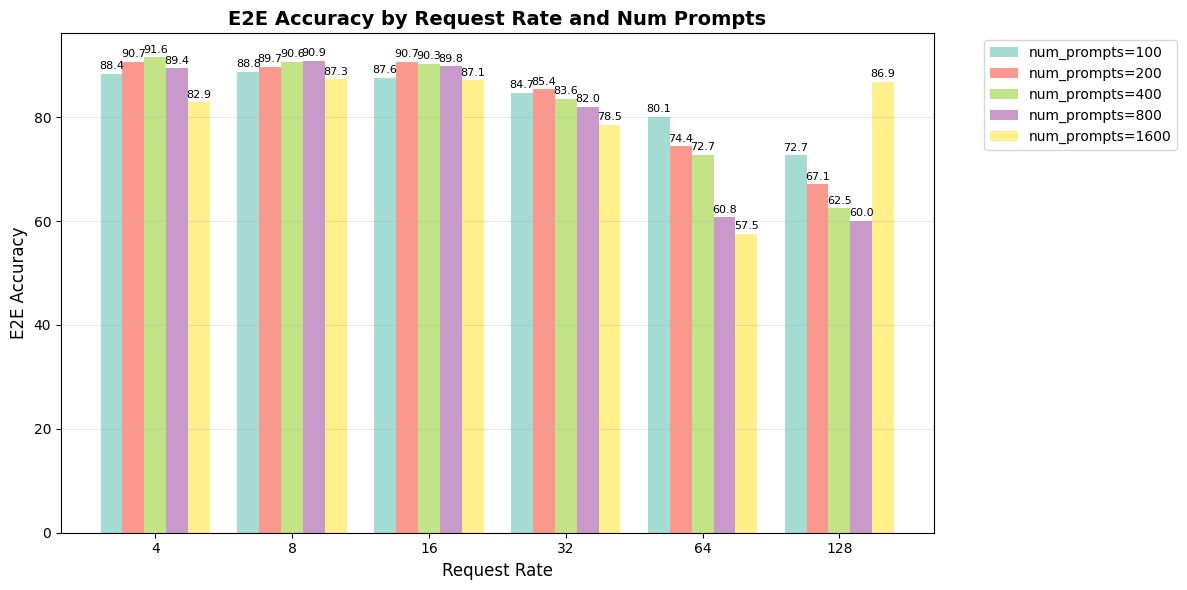

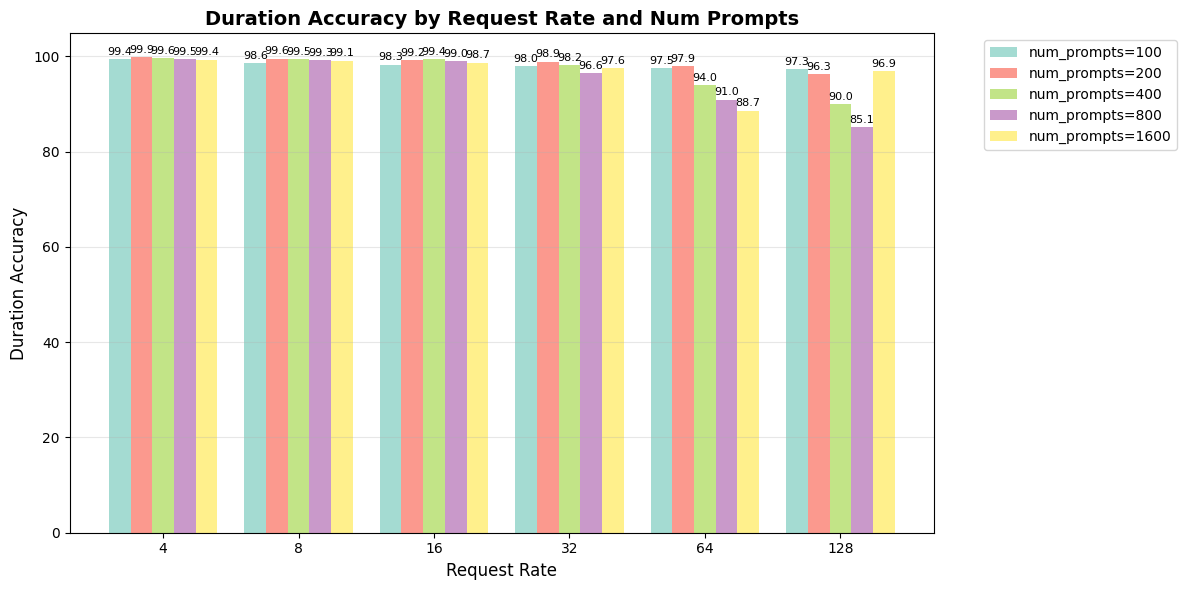

In [49]:
 # Calculate and plot
averaged_data = plot_all_metrics(plotting_data, sweep_configs, x_axis, y_axis)

[100, 200, 400, 800, 1600]
[np.float64(74.03891759892454), np.float64(74.54423602421652), np.float64(76.85020726505292), np.float64(78.61524885260232), np.float64(76.78061188405675), np.float64(75.86739324269546), np.float64(74.35725064421882), np.float64(75.37017308094647), np.float64(80.22268175379546), np.float64(82.6402050277255), np.float64(81.76872001581955), np.float64(75.14886991041057), np.float64(72.2535354607216), np.float64(78.45242467976216), np.float64(77.95541460730888), np.float64(79.58544361825344), np.float64(81.64687656161412), np.float64(81.41841099422508), np.float64(75.22776521702373), np.float64(73.80164765556265), np.float64(77.5906165231199), np.float64(80.22890190684984), np.float64(82.4607155329258), np.float64(82.32044400755395), np.float64(79.63502015396223), np.float64(75.19857575226064), np.float64(75.3857507947851), np.float64(77.7698470550673), np.float64(81.52528795405789), np.float64(78.74582926667205), np.float64(78.64252712878177), np.float64(81.109

ValueError: x and y must have same first dimension, but have shapes (5,) and (195,)

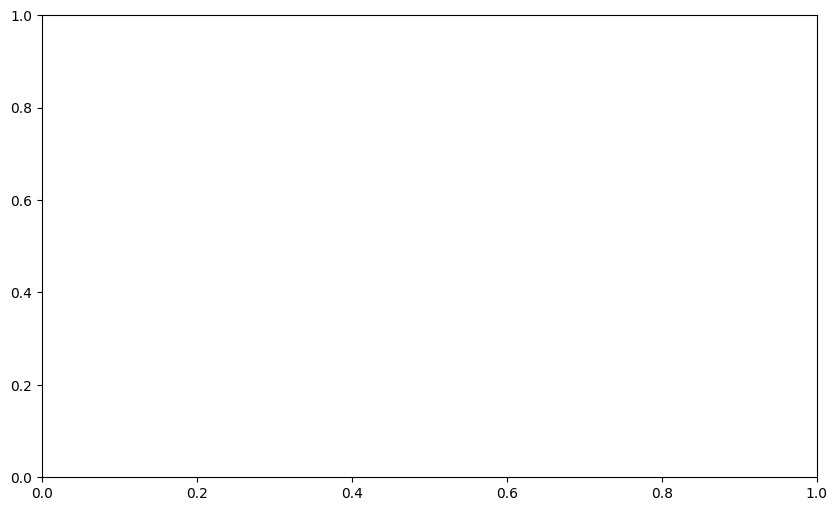

In [4]:

plot_results(plotting_data, x_axis, y_axis, sweep_configs, plot_type="line")